# Libraries

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import month_plot
import seaborn as sns
from pmdarima import auto_arima

# Objectives

Project Summary
The project involves a comprehensive Time Series Aanslysis (TSA) of the Air Passengers dataset, which records monthly totals of a US airline passengers from 1949 to 1960. The main objective of this analysis is:
 - understand the underlying trends and seasonality of the data
 - make accurate forcasts for feature passenger numbers

# Data Loading and Preprocessing

In [172]:
air_passengers = pd.read_csv("AirPassengers.csv")

air_passengers['Month'] = pd.to_datetime (air_passengers['Month'], format = "%Y-%m")
# converts the Month column from a string into a datetime object 

air_passengers = air_passengers.set_index('Month')
# sets the Month column as an index of the dataframe

air_passengers = air_passengers.asfreq('MS')
# sets the frequency of the dataframe's index to MS (Month Start), if there is a missing date it fills with NAN

air_passengers.rename(columns = {"#Passengers": "Number of Passengers"}, inplace = True)
# change the col name for better readability



#  EDA

In [173]:
""" 
The number of Passengers over time
-the plot below shows the monthly airline passenger numbers over 4 decades 
-we can observe a number of features in the plot
 1. the air passenger numbers show a clear seasonal pattern. we can see that the peak of the passenger number consistently occur in August 
 since this in in the summer holiday period, the increase can be explained by the surge in the travel demand in this period
 2. conversely we observe the lowest number of passengers between nov and feb. this dip suggests reduced travel activity in winter,
may be attributed to the cold weather, post hodliday dynameics
3. we also observe a noticable upward trend in the number of passengers over the years. This suggests the airline industry is growing 
and air travel is becoming more accessible
 """


' \nThe number of Passengers over time\n-the plot below shows the monthly airline passenger numbers over 4 decades \n-we can observe a number of features in the plot\n 1. the air passenger numbers show a clear seasonal pattern. we can see that the peak of the passenger number consistently occur in August \n since this in in the summer holiday period, the increase can be explained by the surge in the travel demand in this period\n 2. conversely we observe the lowest number of passengers between nov and feb. this dip suggests reduced travel activity in winter,\nmay be attributed to the cold weather, post hodliday dynameics\n3. we also observe a noticable upward trend in the number of passengers over the years. This suggests the airline industry is growing \nand air travel is becoming more accessible\n '

In [174]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = air_passengers.index, y = air_passengers['Number of Passengers']))
fig.update_layout(
    title = 'US Monthly Airline Passenger Numbers from 1949 to 1960',
    yaxis_title = 'Milllions'
)
fig.update_xaxes(rangeslider_visible = True)
fig.show()

# Decomposition

In [175]:
"""
we use the decomposition method to breakdowon the time series into three components: trend, sesonality and residual
- The trend component represents the long term direction of the time series data over time, 
whether its increasing, decreasing or constant. here, in the air passenger time series we see see a steady 
rise in the number of passengers over time
- The seasonal component identifies a recurring fluctuations that occur at specific time intervals, weekly, 
monthly, yearly, etc
the seaonl component of the air passengers data shows the passenger number peak occurs in the summer months. 
this is in agreement with our observation above
- The residual component represents random fluctuations also called white noise that cant be attributed to 
the seasonal or trend components. in the resid subplot, we can see that most fluctuations are small, and 
we dont see an upward or downward trend. this show that our model fitted well with the time series data 
catputured most important part of the data. 

"""

'\nwe use the decomposition method to breakdowon the time series into three components: trend, sesonality and residual\n- The trend component represents the long term direction of the time series data over time, \nwhether its increasing, decreasing or constant. here, in the air passenger time series we see see a steady \nrise in the number of passengers over time\n- The seasonal component identifies a recurring fluctuations that occur at specific time intervals, weekly, \nmonthly, yearly, etc\nthe seaonl component of the air passengers data shows the passenger number peak occurs in the summer months. \nthis is in agreement with our observation above\n- The residual component represents random fluctuations also called white noise that cant be attributed to \nthe seasonal or trend components. in the resid subplot, we can see that most fluctuations are small, and \nwe dont see an upward or downward trend. this show that our model fitted well with the time series data \ncatputured most imp

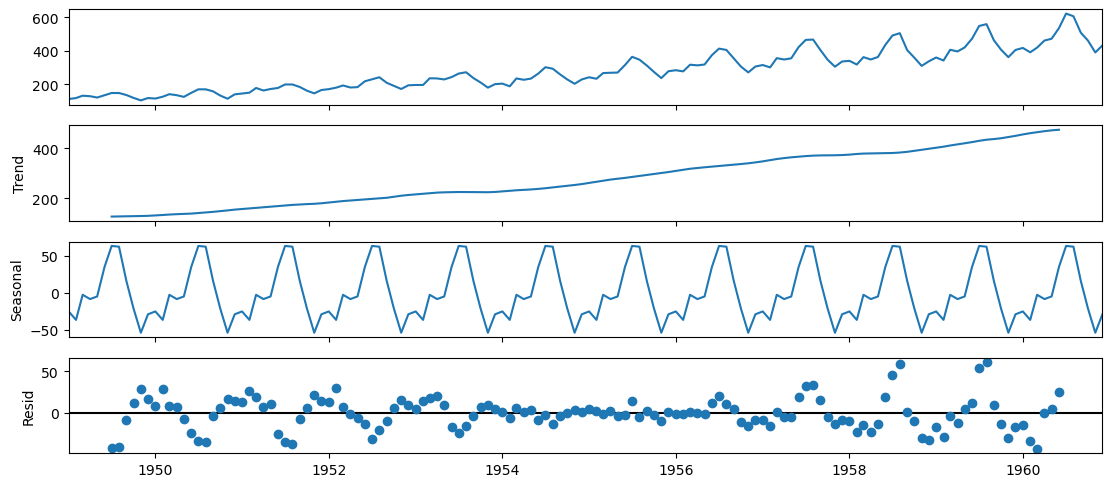

In [176]:
decomposition = seasonal_decompose (air_passengers, period = 12)
fig = decomposition.plot()
fig.set_size_inches(12,5)
plt.show()

# 

# Test for stationarity 

In [177]:
"""
stationarity is important for time series analysis because many forecasting models like ARIMA and SARIMAX
 assume the time series data being modeled is stationary. 
 
 - stationary time series has statisticl properties such as mean, variance and autocorelation that dont change over time


 Test for sationrity
 - we can plot the time series and visualy inspect for seasonality and trends. their absence indicates the data is stationry
 - we can also use statitcal methods
 - the most commonly used statistical method is Augmented Dickey-Fuller (ADF) test, 
 - ADF checks for the presence of unit roots, which suggests the data is stationary
hypotheses
ho : the time series has a unit root : stationary
h1 : the time series has no unit root : non stationary
   """

'\nstationarity is important for time series analysis because many forecasting models like ARIMA and SARIMAX\n assume the time series data being modeled is stationary. \n \n - stationary time series has statisticl properties such as mean, variance and autocorelation that dont change over time\n\n\n Test for sationrity\n - we can plot the time series and visualy inspect for seasonality and trends. their absence indicates the data is stationry\n - we can also use statitcal methods\n - the most commonly used statistical method is Augmented Dickey-Fuller (ADF) test, \n - ADF checks for the presence of unit roots, which suggests the data is stationary\nhypotheses\nho : the time series has a unit root : stationary\nh1 : the time series has no unit root : non stationary\n   '

In [178]:
keys = ['test statistic', 'p value', '# lags', '# obervations']
result = adfuller (air_passengers)
for k, v in zip(keys, result):
    print(f"{k} : {v:.4f}")
if result[1] < 0.05:
    print(f"The time series is stationary")
else:
    print(f"The time series is not stationary")

test statistic : 0.8154
p value : 0.9919
# lags : 13.0000
# obervations : 130.0000
The time series is not stationary


# Differencing

In [179]:
""" 
Differencing

- the p value from ADF test as well as the plot above show that the air passenger time series is not stionary

- we can transform non stationary data to stationary using the differncing method
- differncing removes trends, seasonality and stabilizes variance

  1st differncing subtracts previous observation from the current one , = yt - yt-1
  if the data still non stationary, 2nd differencing can be used = (yt - yt-1) - (yt-1  -yt-2)
  if time series exhibits seasonal patterns, seasonl differeninc can be used = yt - yt-s  

  because the air passenger time series exhibits anual seasonality, seasonl diferencing with period of 12 
  was applied to make the time series staionary
  as we can see from the ADF test below, when seasonl differening is applied the p value drops to less than 0.05

"""
first_difference = air_passengers.diff(1).dropna()
first_result = adfuller(first_difference)
seasonal_difference = air_passengers.diff(12).dropna()
seasonal_result = adfuller (seasonal_difference)

print(f"first_difference :") 
for k, v in zip(keys, first_result):
    print(f"{k} : {v:.4f}")
if result[1] < 0.05:
    print(f"The time series  is stationary")
else:
    print(f"The time series is not stationary")

    
print(f"seasonal difference :")
for k, v in zip(keys, seasonal_result):
    print(f"{k} : {v:.4f}")
if result[1] < 0.05:
    print(f" The time series  is stationary")
else:
    print(f"The time series is not stationary")
   

first_difference :
test statistic : -2.8293
p value : 0.0542
# lags : 12.0000
# obervations : 130.0000
The time series is not stationary
seasonal difference :
test statistic : -3.3830
p value : 0.0116
# lags : 1.0000
# obervations : 130.0000
The time series is not stationary


# Modelling

ARIMA and SARIMAX


ARIMA is amon most widely used methods for time series forecasting.
- it captures the pattern in the data over time by combining three key components

AR (AutoRegression ) uses the relationship between current and previous observations (lags)
-- correlation between yt and yt-1 (lag1), yt and yt-2 (lag2) , yt and y t -k (lagk)

I (Integrated) , applies differencing if necessary to make the time series stationary

MA (Moving Average), the MA model looks at errors from previous obserations and uses it to explain  the current value
 
 yt = mean + theta1 * et-1 + theta2 * et-2 ,,, theta q * et - q + et
  et= observatioin - actual at time t
  q = the number of lagged error used in the model

The ARIMA model takes 3 parameters 
- p, the number of autoregressive terms 
- d, the number of differencing applied to make the series stationary
- q, the number of lagged forecast errors used in the equation

SARIMAX is an extension of ARIMA, created to handle time series data that exhibit seasonal pattern
 - SARIMAX combines seasonal and non-seasonal factors to model short term fluctuation and 
 long term trends and seasonal trends


 - the SARIMAX model takes the following parameters:
   - the ARIMA order (p,d,q)
   - seasonal order
     - p, the number of seasonal autoregressive order
     - d, the number of seasonal differenc
     - q, the number of seasonal lagged forecast errors
     - s, the length of seasonal cycle (12 for monthly series)

# Determining p and q

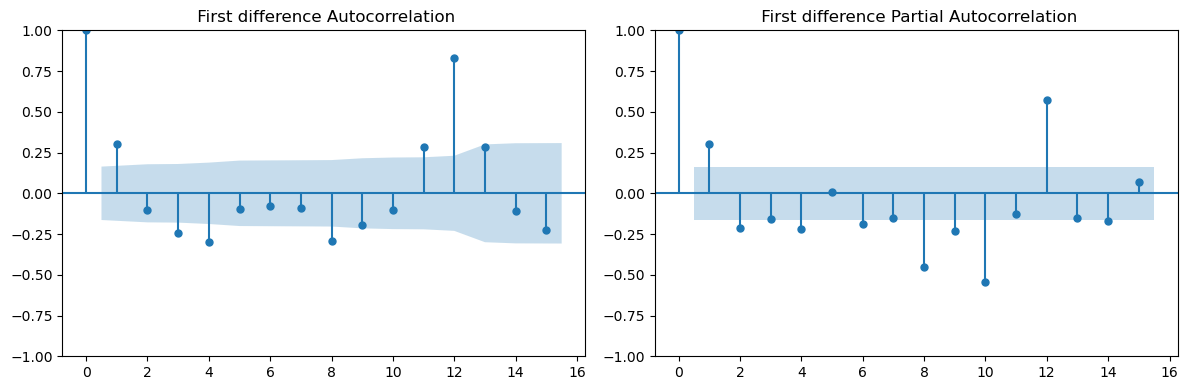

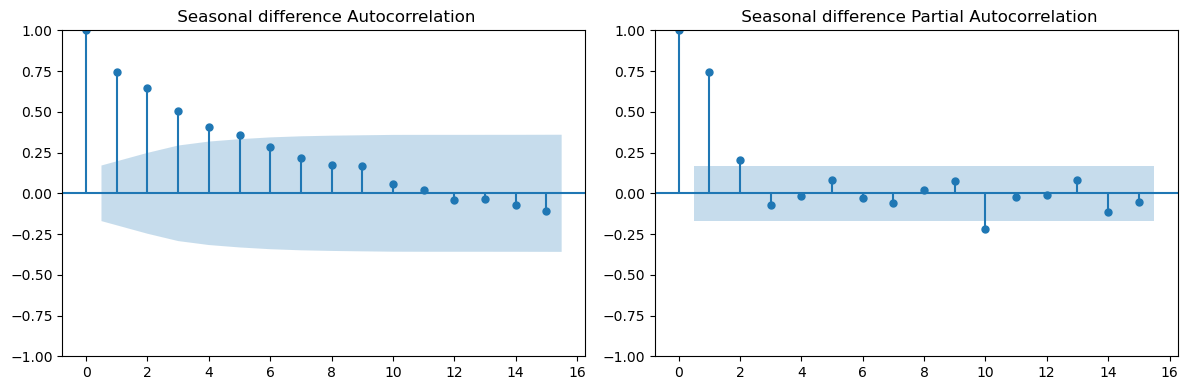

In [180]:
"""
To determine the AR and MA terms we can plot the Autocorrrelation function (ACF) 
and Partial Autcorrelation Function (PACF) of the time seris to check for the significance of the lags

for AR term (p), we use ACF plot, p is defined as the cut-off point where the lag correlation becomes insgnificant
-- as we can see in ACF plot below, the value of p for the air passenger series, first differenced  is 1, seasonal differenced = 4

 --- 
for MA term (q), we use PACF plot, q is defined as the cut-off point where the lag correlation becomes insignificant
--- the value of q for the air passenger, for both first differenced and seasonal difference is 2
"""
plt.figure(figsize = (12, 4))
plt.subplot(121)
plot_acf(first_difference, ax = plt.gca(), lags = 15)
plt.title (" First difference Autocorrelation")
plt.subplot(122)
plot_pacf(first_difference, ax = plt.gca(), lags = 15)
plt.title (" First difference Partial Autocorrelation")
plt.tight_layout()
plt.show()
plt.figure(figsize = (12, 4))
plt.subplot(121)
plot_acf(seasonal_difference, ax = plt.gca(), lags = 15)
plt.title (" Seasonal difference Autocorrelation")
plt.subplot(122)
plot_pacf(seasonal_difference, ax = plt.gca(), lags = 15)
plt.title (" Seasonal difference Partial Autocorrelation")
plt.tight_layout()
plt.show()



# Train-Test Data preparation

In [181]:
""" we will split the time series to train_data and test_data for model evaluation purpose
- the train_data will be used for model fitting
-- the test_data will be used for evaluation
"""
train_data, test_data = air_passengers [air_passengers.index < '1957-01-01'], air_passengers [air_passengers.index >= '1957-01-01']

# Model Fitting

In [182]:
""" 
Since the air passenger time series exhibits seasonality, we will use SARIMAX to model the series 
as described above SARIMAX factors the non-seasonal (p,d,q) and seasonal orders (p,d,q,s)

when the model fit to the training data with the p, q values determined above the model fails to estimate the starting parameters because the observation are small,
 so we will have to reduce the p and q values
 we can also estimate the optimal p, q value using auto_arima method

"""
out_model = auto_arima(air_passengers,seasonal = True, m = 12, trace = True)

# the automodel search shows that the optimal parameters for the train data is (1,1,0)(1,1,0)[12]   




model = SARIMAX (train_data, order = (1,1,0), seasonal_order = (1,1,0,12))
model_fit = model.fit(disp = 0)




# Forecasting

In [191]:

predictions = model_fit.predict(0, end = len(train_data) + len(test_data)-1)
fig = go.Figure()
fig.add_trace(go.Scatter(x = train_data.index, y = train_data['Number of Passengers'], mode = 'lines', name = 'Train'))
fig.add_trace(go.Scatter(x = test_data.index, y = test_data['Number of Passengers'], mode = 'lines', name = 'Test'))
fig.add_trace(go.Scatter(x = air_passengers.index, y = predictions.values, mode = 'lines', name = 'Predictions'))


fig.update_layout(
    title = 'Monthly Passenger Numbers Forecast', xaxis_title = 'Month', yaxis_title = 'Millions'
)
fig.update_xaxes(rangeslider_visible = True)
fig.show()

# Model Evaluation

In [194]:

def mean_absolute_percentage_error (actual, predicted):
    error = np.abs (actual - predicted)
    error_pct = np.mean (error/actual) * 100
    return error_pct

test_index = []
test_pred = model_fit.predict(len(train_data),)
def mean_absolute_percentage_error (actual, predicted):
    error = np.abs (actual - predicted)
    error_pct = np.mean (error/actual) * 100
    return error_pct
train_mean = train_data.values.mean()
test_mean = test_data.values.mean()
train_mape = mean_absolute_percentage_error (train_data.values, train_mean)
test_mape = mean_absolute_percentage_error (test_data.values, test_mean)
train_pred_mape = mean_absolute_percentage_error (train_data.values, predictions[train_data.index].values)
test_pred_mape = mean_absolute_percentage_error (test_data.values, predictions[test_data.index].values)
print (f"mape of train sample : {train_mape:.2f} %")
print (f"mape of test sample: {test_mape:.2f} %")
print (f"mape of train pred : {train_pred_mape:.2f} %")
print (f"mape of test pred: {test_pred_mape:.2f} %")






mape of train sample : 30.89 %
mape of test sample: 15.18 %
mape of train pred : 41.56 %
mape of test pred: 18.20 %


In [195]:
def say_hello():
    print('hi')